# 3D Image Segmentation

### Imports

In [1]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from dataclasses import dataclass
import matplotlib.patches as patches
from skimage.measure import label as sk_label, regionprops
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing, label as cc_label
from scipy.spatial.distance import directed_hausdorff

@dataclass
class Config:
    dicom_base: str = "../dataset"
    patient_ref: str = "10_AP_Ax2.50mm"
    seg_filename: str = "10_AP_Ax2.50mm_ManualROI_Tumor.dcm"
    intensity_lower: int = -50
    intensity_upper: int = 150
    roi_margin: int = 5
    min_voxels: int = 500
    # thresholds adaptive or fixed
    use_adaptive_threshold: bool = False
    debug: bool = True  # print intermediate debug info

### Funzioni di I/O DICOM

In [3]:
def load_ct_volume(folder_path: str):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(folder_path)
    assert series_ids, f"Nessuna serie DICOM in {folder_path}"
    file_names = reader.GetGDCMSeriesFileNames(folder_path, series_ids[0])
    reader.SetFileNames(file_names)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)
    slope = float(img.GetMetaData('0028|1053')) if img.HasMetaDataKey('0028|1053') else 1.0
    intercept = float(img.GetMetaData('0028|1052')) if img.HasMetaDataKey('0028|1052') else 0.0
    arr = arr * slope + intercept
    print(f"[IO-CT] {os.path.basename(folder_path)} → shape={arr.shape}, spacing={img.GetSpacing()}")
    return img, arr


def load_segmentation(dcm_path: str, ref_img: sitk.Image):
    seg = sitk.ReadImage(dcm_path)
    frames = sitk.GetArrayFromImage(seg)
    import pydicom
    ds = pydicom.dcmread(dcm_path)
    depth, height, width = ref_img.GetSize()[2], ref_img.GetSize()[1], ref_img.GetSize()[0]
    full_mask = np.zeros((depth, height, width), dtype=np.uint8)
    for idx, frame_meta in enumerate(ds.PerFrameFunctionalGroupsSequence):
        zpos = float(frame_meta.PlanePositionSequence[0].ImagePositionPatient[2])
        slice_indices = [i for i in range(depth)
                         if np.isclose(ref_img.TransformIndexToPhysicalPoint((0,0,i))[2], zpos)]
        iz = slice_indices[0]
        full_mask[iz] = (frames[idx] > 0)
    return seg, full_mask

### Compute bounding box and centroid

In [4]:
def compute_all_rois(mask: np.ndarray, margin: int) -> List[Dict[str, Tuple]]:
    """
    Identify all connected components in the mask and for each:
      - compute its 3D bounding-box (inclusive) with optional margin
      - compute its centroid
      - perform consistency checks
      - visualize the bounding-box & centroid on the slice of the centroid
    
    Returns a list of dicts, each containing:
      'label'     : integer label of the component
      'bbox'      : ((z0,z1),(y0,y1),(x0,x1)) inclusive bounds with margin
      'centroid'  : (cz, cy, cx) integer coordinates
    """
    results = []
    # 1) Label the mask
    lbl = sk_label(mask)
    # 2) Loop through all regions
    for region in regionprops(lbl):
        label_id = region.label
        # skip trivial regions if desired
        if region.area == 0:
            continue

        # unpack the raw bbox from regionprops: (min_z, min_y, min_x, max_z_exc, max_y_exc, max_x_exc)
        min_z, min_y, min_x, max_z_exc, max_y_exc, max_x_exc = region.bbox
        # convert exclusive max to inclusive index
        max_z, max_y, max_x = max_z_exc - 1, max_y_exc - 1, max_x_exc - 1
        # get centroid (z, y, x)
        cz, cy, cx = map(int, region.centroid)

        # apply margin and clip to volume bounds
        z0 = max(0, min_z - margin)
        z1 = min(mask.shape[0] - 1, max_z + margin)
        y0 = max(0, min_y - margin)
        y1 = min(mask.shape[1] - 1, max_y + margin)
        x0 = max(0, min_x - margin)
        x1 = min(mask.shape[2] - 1, max_x + margin)
        roi = ((z0, z1), (y0, y1), (x0, x1))

        # consistency checks
        assert mask[min_z, :, :].any(), f"No tumor voxel at min_z={min_z} for label {label_id}"
        assert mask[max_z, :, :].any(), f"No tumor voxel at max_z={max_z} for label {label_id}"
        assert mask[:, min_y, :].any(), f"No tumor voxel at min_y={min_y} for label {label_id}"
        assert mask[:, max_y, :].any(), f"No tumor voxel at max_y={max_y} for label {label_id}"
        assert mask[:, :, min_x].any(), f"No tumor voxel at min_x={min_x} for label {label_id}"
        assert mask[:, :, max_x].any(), f"No tumor voxel at max_x={max_x} for label {label_id}"
        assert mask[cz, cy, cx] == 1, f"Centroid {cz,cy,cx} not on a tumor voxel for label {label_id}"

        # visualize on the centroid slice
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(ref_vol[cz], cmap='gray')  # assumes ref_vol in scope
        ax.contour(mask[cz], colors='g', linewidths=1)
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.plot(cx, cy, 'ro')
        ax.set_title(f"Label {label_id}: slice {cz}, bbox (red), centroid (red dot)")
        ax.axis('off')
        plt.show()

        # collect results
        results.append({
            'label': label_id,
            'bbox': roi,
            'centroid': (cz, cy, cx)
        })

    return results

### Region growing with ROI enforcement

In [5]:
class RegionGrowing3D:
    def __init__(self, volume: np.ndarray, lower: int, upper: int, roi: tuple = None, debug: bool = False):
        """
        volume: 3D numpy array del CT
        lower, upper: soglie HU
        roi: ((z0,z1),(y0,y1),(x0,x1)) per limitare la crescita
        debug: se True stampa statistiche
        """
        self.vol = volume
        self.lower, self.upper = lower, upper
        self.roi = roi
        self.debug = debug

    def _in_roi(self, z, y, x):
        if self.roi is None:
            return True
        (z0, z1), (y0, y1), (x0, x1) = self.roi
        return (z0 <= z <= z1) and (y0 <= y <= y1) and (x0 <= x <= x1)

    def segment(self, seed: tuple):
        """
        seed: (z,y,x) di partenza
        restituisce tuple (mask, stats)
        - mask: array uint8 0/1 della segmentazione
        - stats: dizionario con conteggi di voxels messi in coda, accettati,
                 scartati per ROI, scartati per intensità
        """
        mask = np.zeros_like(self.vol, dtype=bool)
        stack = [seed]
        stats = {
            'queued':    1,
            'accepted':  0,
            'roi_reject':0,
            'int_reject':0
        }

        while stack:
            z, y, x = stack.pop()
            # già visitato?
            if mask[z, y, x]:
                continue

            # controllo ROI
            if not self._in_roi(z, y, x):
                stats['roi_reject'] += 1
                continue

            # controllo intensità
            hu = self.vol[z, y, x]
            if not (self.lower <= hu <= self.upper):
                stats['int_reject'] += 1
                continue

            # accetta il voxel
            mask[z, y, x] = True
            stats['accepted'] += 1

            # aggiungi vicini
            for dz, dy, dx in [(1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1)]:
                nz, ny, nx = z+dz, y+dy, x+dx
                if (0 <= nz < mask.shape[0] and
                    0 <= ny < mask.shape[1] and
                    0 <= nx < mask.shape[2] and
                    not mask[nz, ny, nx]):
                    stack.append((nz, ny, nx))
                    stats['queued'] += 1

        # converto in 0/1
        mask_uint8 = mask.astype(np.uint8)

        if self.debug:
            print("=== RegionGrowing3D stats ===")
            print(f"  queued:     {stats['queued']}")
            print(f"  accepted:   {stats['accepted']}")
            print(f"  roi_reject: {stats['roi_reject']}")
            print(f"  int_reject: {stats['int_reject']}")
            print(f"  final voxels: {mask_uint8.sum()}")
            print("=============================")

        return mask_uint8, stats

### Post‐processing

In [6]:
def clean_mask(mask: np.ndarray, min_vox: int):
    filled = binary_fill_holes(mask)
    opened = binary_opening(filled)
    closed = binary_closing(opened)
    labs, num = cc_label(closed)
    out = np.zeros_like(mask)
    for lab_id in range(1, num+1):
        comp = (labs == lab_id)
        if comp.sum() >= min_vox:
            out[comp] = 1
    return out

### Classe per le metriche

In [7]:
class EvalMetrics:
    @staticmethod
    def dice(gt: np.ndarray, pred: np.ndarray) -> float:
        inter = np.logical_and(gt, pred).sum()
        return 2 * inter / (gt.sum() + pred.sum()) if (gt.sum()+pred.sum())>0 else 0.0

    @staticmethod
    def jaccard(gt: np.ndarray, pred: np.ndarray) -> float:
        inter = np.logical_and(gt, pred).sum()
        uni   = np.logical_or(gt, pred).sum()
        return inter / uni if uni>0 else 0.0

    @staticmethod
    def precision(gt: np.ndarray, pred: np.ndarray) -> float:
        tp = np.logical_and(gt, pred).sum()
        fp = np.logical_and(~gt, pred).sum()
        return tp / (tp + fp) if (tp+fp)>0 else 0.0

    @staticmethod
    def recall(gt: np.ndarray, pred: np.ndarray) -> float:
        tp = np.logical_and(gt, pred).sum()
        fn = np.logical_and(gt, ~pred).sum()
        return tp / (tp + fn) if (tp+fn)>0 else 0.0

    @staticmethod
    def hausdorff(gt: np.ndarray, pred: np.ndarray, spacing: tuple) -> float:
        # Estrai i contorni voxel come clouds di punti 3D
        gt_pts   = np.argwhere(gt)
        pred_pts = np.argwhere(pred)
        # Converti da indice a coordinate fisiche (mm)
        gt_phys   = gt_pts   * np.array(spacing)[::-1]  # z,y,x → mm
        pred_phys = pred_pts * np.array(spacing)[::-1]
        # Calcola Hausdorff bidirezionale
        d1 = directed_hausdorff(gt_phys,   pred_phys)[0]
        d2 = directed_hausdorff(pred_phys, gt_phys)[0]
        return max(d1, d2)

    @staticmethod
    def vol_diff(gt: np.ndarray, pred: np.ndarray, spacing: tuple) -> float:
        voxel_vol = np.prod(spacing)  # mm³
        # forza cast a Python int per evitare overflow uint64
        n_gt   = int(gt.sum())
        n_pred = int(pred.sum())
        return abs(n_pred - n_gt) * voxel_vol / 1000  # cm³


### Visualizzazione slice con overlay

In [8]:
def overlay_slice(ct: np.ndarray, gt: np.ndarray, auto: np.ndarray, z: int):
    plt.figure(figsize=(5,5))
    plt.imshow(ct[z], cmap='gray')
    if np.any(gt[z]): plt.contour(gt[z], colors='g', linewidths=1)
    if np.any(auto[z]): plt.contour(auto[z], colors='r', linewidths=1)
    plt.title(f"Slice {z}")
    plt.axis('off')
    plt.show()

def overlay_errors(ct, gt, auto, z):
    fp = np.logical_and(~gt, auto)
    fn = np.logical_and(gt, ~auto)
    plt.figure(figsize=(5,5))
    plt.imshow(ct[z], cmap='gray')
    plt.imshow(fp[z], cmap='Reds',   alpha=0.5, vmin=0, vmax=1)  # false positive in rosso
    plt.imshow(fn[z], cmap='Blues',  alpha=0.5, vmin=0, vmax=1)  # false negative in blu
    plt.title(f"Errori slice {z}: Rosso=FP, Blu=FN")
    plt.axis('off')
    plt.show()

### MAIN

### Load

In [9]:
cfg = Config()
ref_ct, ref_vol = load_ct_volume(os.path.join(cfg.dicom_base, cfg.patient_ref))
seg_img, ref_mask = load_segmentation(os.path.join(cfg.dicom_base, cfg.seg_filename), ref_ct)

[IO-CT] 10_AP_Ax2.50mm → shape=(207, 512, 512), spacing=(0.78125, 0.78125, 2.5)


### ROI and centroid

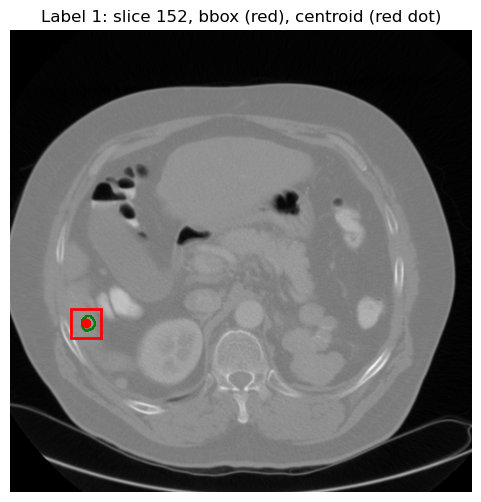

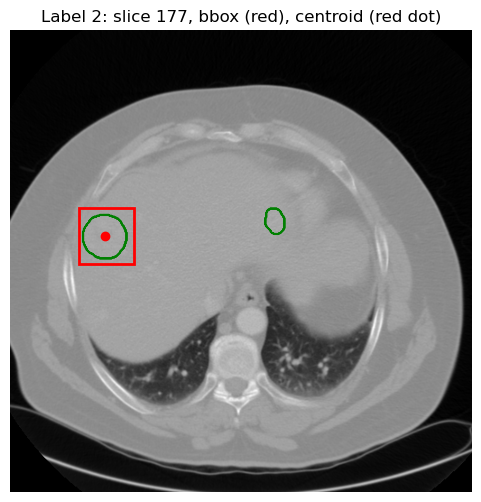

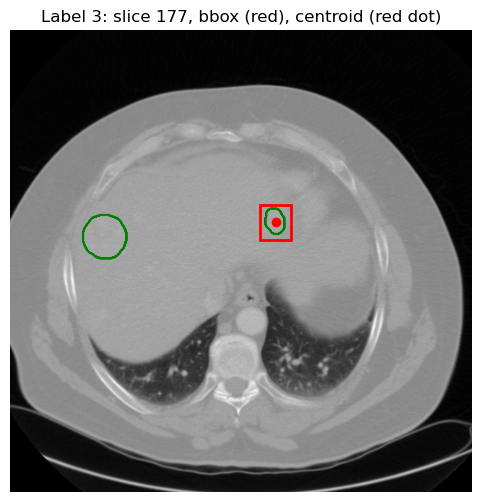

Component 1: bbox=((147, 158), (309, 341), (67, 100)), centroid=(152, 324, 84)
Component 2: bbox=((166, 188), (197, 259), (76, 137)), centroid=(177, 228, 105)
Component 3: bbox=((171, 183), (193, 232), (277, 311)), centroid=(177, 212, 294)


In [10]:
rois = compute_all_rois(ref_mask, margin=5)
for entry in rois:
    print(f"Component {entry['label']}: bbox={entry['bbox']}, centroid={entry['centroid']}")

### Compute segmentation

In [11]:
results = []
for entry in rois:
    comp_id = entry['label']        # rinominato per non sovrascrivere cc_label
    seed    = entry['centroid']     # (z,y,x)
    (min_z, max_z), (min_y, max_y), (min_x, max_x) = entry['bbox']
    
    if cfg.debug:
        z, y, x = seed
        hu_val = ref_vol[z, y, x]
        print(f"\n--- Component {comp_id} ---")
        print(f"  Seed (z,y,x): {seed}, HU={hu_val}")
        print(f"  ROI bounds: Z[{min_z},{max_z}], Y[{min_y},{max_y}], X[{min_x},{max_x}]")

    rg = RegionGrowing3D(
        volume=ref_vol,
        lower=cfg.intensity_lower,
        upper=cfg.intensity_upper,
        roi=None,
        debug=cfg.debug
    )
    auto_raw, stats = rg.segment(seed)

    if cfg.debug:
        print(f"  Raw voxels:   {auto_raw.sum()}")

    auto = clean_mask(auto_raw, cfg.min_voxels)

    if cfg.debug:
        print(f"  Clean voxels: {auto.sum()}\n")

    results.append({
        'label':      comp_id,
        'seed':       seed,
        'roi':        ((min_z, max_z), (min_y, max_y), (min_x, max_x)),
        'raw_mask':   auto_raw,
        'final_mask': auto,
        'stats':      stats
    })


--- Component 1 ---
  Seed (z,y,x): (152, 324, 84), HU=93.0
  ROI bounds: Z[147,158], Y[309,341], X[67,100]
=== RegionGrowing3D stats ===
  queued:     44272446
  accepted:   13811620
  roi_reject: 0
  int_reject: 5811168
  final voxels: 13811620
  Raw voxels:   13811620
  Clean voxels: 13405415


--- Component 2 ---
  Seed (z,y,x): (177, 228, 105), HU=47.0
  ROI bounds: Z[166,188], Y[197,259], X[76,137]
=== RegionGrowing3D stats ===
  queued:     44272446
  accepted:   13811620
  roi_reject: 0
  int_reject: 5811168
  final voxels: 13811620
  Raw voxels:   13811620
  Clean voxels: 13405415


--- Component 3 ---
  Seed (z,y,x): (177, 212, 294), HU=115.0
  ROI bounds: Z[171,183], Y[193,232], X[277,311]
=== RegionGrowing3D stats ===
  queued:     44272446
  accepted:   13811620
  roi_reject: 0
  int_reject: 5811168
  final voxels: 13811620
  Raw voxels:   13811620
  Clean voxels: 13405415



In [ ]:
# --- Estrai auto_mask dai results ---
auto_mask = results[0]['final_mask']

# --- Calcolo metriche su ref_vol/ref_mask ---
spacing = ref_ct.GetSpacing()
d   = EvalMetrics.dice     (ref_mask, auto_mask)
j   = EvalMetrics.jaccard  (ref_mask, auto_mask)
p   = EvalMetrics.precision(ref_mask, auto_mask)
r   = EvalMetrics.recall   (ref_mask, auto_mask)
hd  = EvalMetrics.hausdorff(ref_mask, auto_mask, spacing)
vd  = EvalMetrics.vol_diff (ref_mask, auto_mask, spacing)

print(f"Dice={d:.4f}, Jaccard={j:.4f}, Precision={p:.4f}, Recall={r:.4f}, Hausdorff={hd:.2f} mm, VolDiff={vd:.2f} cm³\n")

# --- Overlay CT + GT + Auto sul ref_vol ---
mid = ref_vol.shape[0] // 2
for dz in [-10, 0, 10]:
    z = mid + dz
    if 0 <= z < ref_vol.shape[0]:
        overlay_slice(ref_vol, ref_mask, auto_mask, z)

# --- Mappe di errore (FP/FN) sul ref_vol ---
print("\nMappe di errore (FP in rosso, FN in blu):")
for dz in [-10, 0, 10]:
    z = mid + dz
    if 0 <= z < ref_vol.shape[0]:
        overlay_errors(ref_vol, ref_mask, auto_mask, z)